In [1]:
import foolbox
import numpy as np
import torchvision.models as models

from datetime import datetime


In [2]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars
import time as timer

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
import foolbox
import wget
# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset



from art.attacks import *
from art.classifiers import PyTorchClassifier
from art.utils import load_mnist


In [3]:
# LeNet Model definition
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    
#Location for pre-trained model: 
#url="https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h?usp=sharing"
#Saved in  "Models/lenet_mnist_model.pth"

    
pretrained_model = "Models/lenet_mnist_model.pth"
use_cuda=False
    
    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
#device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

# Initialize the network
model = LeNet5().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  False


LeNet5(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

# Section A: Preparing Foolbox

## Foolbox: data conversion function

In [ ]:
def Foolbox_x_y_generator(dataset):
    '''
    will convert a PyTorch dataset to the format required by Foolbox for data processing 
    
    '''
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

    images = next(iter(data_loader))[0].numpy()
    
    #Todo: delete this 
    #labels = np.full((len(dataset),10),0.0,dtype="float32")
    
    labels = dataset.targets.numpy()
            
    return images, labels 
 

## Foolbox: convert training dataset into foolbox nparray format 

In [ ]:
# MNIST Test dataset and dataloader declaration
train_dataset = datasets.MNIST('data/MNIST/', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ]))

x_train_foolbox, y_train_foolbox = Foolbox_x_y_generator(train_dataset)

## Foolbox: attack function  

In [ ]:
def foolbox_attack_demo(attack_title, attack_type,images,labels):
    start_time = time.time()
    
    adversarials = attack_type(images, labels, unpack=False)
    
    distances = np.asarray([a.distance.value for a in adversarials])
    failed_attacks = sum(adv.distance.value == np.inf for adv in adversarials)
    accuracy_on_adversarial = (failed_attacks/len(adversarials))*100 
    
    time_taken = round((time.time() - start_time),2)
    
    print("Foolbox model: Accuracy on pertubed images: {} %, Time taken:{} seconds".format(accuracy_on_adversarial,time_taken))

    
    arr = []
    for each in range(len(adversarials)):
        
        #return predicted class if it exists else, return the original class 
        try:
            predicted_class = adversarials[each].output.argmax()
        except AttributeError:
            predicted_class =  adversarials[each].original_class
            
        #return preturbed image if it exists else, return the original image itself 
        try:
            preturbed_image = adversarials[each].perturbed.reshape(28,28)
        except AttributeError:
            preturbed_image = adversarials[each].unperturbed.reshape(28,28)


            
        arr.append((preturbed_image,
                    adversarials[each].unperturbed.reshape(28,28),
                    adversarials[each].original_class, 
                    predicted_class))

    #the actual adversarial images will be saved locally in a pickle file 
    
    timestamp=datetime.now().strftime("%d_%m_%Y__%H_%M_%S")
    file_name = "data/Adversarial/foolboxadv_" +attack_title+ "_"+timestamp + ".pickle"
    pickle_file = open(file_name,"wb")
    pickle.dump(arr, pickle_file)
    pickle_file.close()
    print("Foolbox: Adversarials for " +attack_title + " saved as pickle file")
    

    return [attack_title,accuracy_on_adversarial, time_taken]


# Section B: Preparing IBM ART

## IBM ART: data conversion function 

In [4]:
def ART_x_y_generator(dataset):
    '''
    will convert a PyTorch dataset to the format required by IBM ART for data processing 
    
    '''
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

    images = next(iter(data_loader))[0].numpy()
    
    labels = np.full((len(dataset),10),0.0,dtype="float32")
    
    target_list = dataset.targets.numpy()
    
    for index, target in enumerate(target_list):
        labels[index][target]=1
        
    return images, labels , target_list
 

In [5]:
# MNIST Test dataset and dataloader declaration
train_dataset = datasets.MNIST('data/MNIST/', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ]))

x_train_IBM, y_train_IBM, y_train_oldformat_IBM = ART_x_y_generator(train_dataset)

# MNIST Test dataset and dataloader declaration
test_dataset = datasets.MNIST('data/MNIST/', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ]))

x_test_IBM, y_test_IBM, y_test_oldformat_IBM = ART_x_y_generator(test_dataset)


## Prepare classifer for IBM ART

In [6]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

min_pixel_value=0.0
max_pixel_value=1.0 

classifier = PyTorchClassifier(model=model
                               , clip_values=(min_pixel_value, max_pixel_value)
                               , loss=criterion
                               , optimizer=optimizer
                               , input_shape=(1, 28, 28)
                               , nb_classes=10)


In [7]:

classifier.fit(x_train_IBM, y_train_IBM, batch_size=64, nb_epochs=3)

predictions = classifier.predict(x_test_IBM)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_IBM, axis=1)) / len(y_test_IBM)
print('Accuracy on benign test examples: {}%'.format(accuracy * 100))

Accuracy on benign test examples: 98.87%


## IBM ART: attack function

In [8]:
def ART_attack_demo(attack_title, attack_type,classifier,images,labels,labels_original_format):
    start_time = time.time()
    
    attack = attack_type
    images_adv = attack.generate(x=images)
    predictions = classifier.predict(images_adv)
    
    time_taken = round((time.time() - start_time),2)
    accuracy_on_adversarial = (np.sum(np.argmax(predictions, axis=1) == np.argmax(labels, axis=1)) / len(labels))*100
    
    print("IBM ART: Accuracy on pertubed images: {} %, Time taken:{} seconds".format(accuracy_on_adversarial,time_taken))
    
    #the actual adversarial images will be saved locally in a pickle file 
    
    timestamp=datetime.now().strftime("%d_%m_%Y__%H_%M_%S")
    file_name = "data/Adversarial/IBMART_Image_and_label_" +attack_title+ "_"+timestamp + ".pickle"
    pickle_file = open(file_name,"wb")
    adversarials = [images_adv, labels_original_format]
    pickle.dump(adversarials, pickle_file)
    pickle_file.close()
    print("IBM ART: Adversarials for " +attack_title + " saved as pickle file")

    return [attack_title,accuracy_on_adversarial, time_taken]



# Section C: Attack comparison 

## Initiate models and data

In [9]:
number_of_samples = 30000


x_train_IBM = x_train_IBM[:number_of_samples]
y_train_IBM = x_train_IBM[:number_of_samples]
y_train_oldformat_IBM = y_train_oldformat_IBM [:number_of_samples]


## 1. FGSM

In [10]:
art_attack_type = FastGradientMethod(classifier=classifier)
art_adversarials = ART_attack_demo("FastGradientMethod",art_attack_type,classifier,x_train_IBM,y_train_IBM,y_train_oldformat_IBM)




c:\program files\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


IBM ART: Accuracy on pertubed images: 0.0 %, Time taken:107.7 seconds
IBM ART: Adversarials for FastGradientMethod saved as pickle file


## 2. Carlini Wagner

In [ ]:
art_attack_type = CarliniLInfMethod(classifier=classifier)
art_adversarials = ART_attack_demo("CarliniLInfMethod",art_attack_type,classifier,x_train_IBM,y_train_IBM,y_train_oldformat_IBM)



## 3. DeepFool 

In [ ]:
art_attack_type = DeepFool(classifier=classifier)
art_adversarials = ART_attack_demo("DeepFool",art_attack_type,classifier,x_train_IBM,y_train_IBM,y_train_oldformat_IBM)



# Foolbox code

In [ ]:
x_train_foolbox = x_train_foolbox [:number_of_samples] 
y_train_foolbox = y_train_foolbox [:number_of_samples]


foolboxmodel = foolbox.models.PyTorchModel(model, bounds=(0, 1), num_classes=10)


## 1. FGSM 

In [ ]:
foolbox_attack_type = foolbox.attacks.FGSM(foolboxmodel)
foolbox_adversarials = foolbox_attack_demo("FGSM", foolbox_attack_type,x_train_foolbox,y_train_foolbox)

## 2. Carlini Wagner 

## 3. DeepFool 

# Pickle Code to read data 

## IBM - Pickle and Shape 

In [11]:
import pickle
def pickleretrieve(file_name):
    variable  = pickle.load( open( file_name, "rb" ) )
    return variable


In [12]:
sample_file = 'data/Adversarial/IBMART_Image_and_label_FastGradientMethod_25_01_2020__10_15_58.pickle'
IBM_FGSM_Adversarials = pickleretrieve(sample_file)


In [13]:
IBM_adversarial_images,IBM_original_labels = iter(IBM_FGSM_Adversarials) 
IBM_adversarial_images.shape

(30000, 1, 28, 28)

3


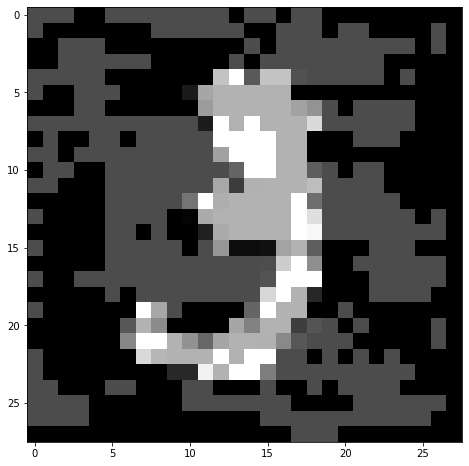

In [17]:
print(IBM_original_labels[10])
import matplotlib.pyplot as plt 
img = IBM_adversarial_images[10].reshape((28,28))
plt.imshow(img, cmap="gray")
plt.show()


3